## Data preprocessing

To run SANGO, the first step is to create an AnnData object from the raw data.

The h5ad file should contain cells as obs and peaks as var. Within the 'var' category, at least three columns - 'chr', 'start', and 'end' - are required to denote the genomic region of each peak.

In [1]:
import warnings
warnings.filterwarnings("ignore")
import scanpy as sc
import pandas as pd
import numpy as np

### load data
 For cross-technology platform data, alignment operations are required during the preprocessing process due to the different feature dimensions and peak ranges among the data. Below, we outline the process of aligning data from different technology platforms. Here, we provide preprocessed data from cross-technology platforms that can be directly input into CACNN for execution.

In [ ]:
# # load data
# adata_reference = sc.read_h5ad("./data/MosP1.h5ad")
# adata_query = sc.read_h5ad("./data/Cerebellum.h5ad")

# # mapping of genomes
# df_query = {
#     "chrom": adata_query.var['chrom'].values,
#     "start": adata_query.var["chromStart"].values,
#     "end": adata_query.var["chromEnd"].values,
#     "peaks": adata_query.var_names.values,
# }
# df_query = pd.DataFrame(df_query)
# df_query.to_csv("preprocess_data/query.bed", header=None, index=None, sep="\t")

# !CrossMap.py bed preprocess_data/mm9ToMm10.over.chain.gz preprocess_data/query.bed preprocess_data/query_crossmap.bed

# df_query = pd.read_csv("preprocess_data/query_crossmap.bed", header=None, sep="\t")

# seq_len = 1344

# query_start_list = []
# query_end_list = []
# for start, end in zip(df_query[1], df_query[2]):
#     mid = (start + end) // 2
#     new_start = max(start, mid - seq_len // 2)
#     new_end = min(end, mid + seq_len // 2)
#     query_start_list.append(new_start)
#     query_end_list.append(new_end)

# df_query_new = {
#     "chrom": df_query[0],
#     "start": query_start_list,
#     "end": query_end_list,
#     "peaks": df_query[3],
# }
# df_query_new = pd.DataFrame(df_query_new)
# df_query_new.to_csv("preprocess_data/query_new.bed", header=None, index=None, sep="\t")

# reference_start_list = []
# reference_end_list = []
# for start, end in zip(adata_reference.var["chromStart"].values, adata_reference.var["chromEnd"].values):
#     start, end = int(start), int(end)
#     mid = (start + end) // 2
#     new_start = max(start, mid - seq_len // 2)
#     new_end = min(end, mid + seq_len // 2)
#     reference_start_list.append(new_start)
#     reference_end_list.append(new_end)

# df_reference = {
#     "chrom": adata_reference.var['chrom'].values,
#     "start": reference_start_list,
#     "end": reference_end_list,
#     "peaks": adata_reference.var_names.values,
# }
# df_reference = pd.DataFrame(df_reference)
# df_reference.to_csv("preprocess_data/reference.bed", header=None, index=None, sep="\t")

# !bedtools intersect -a preprocess_data/query_new.bed -b preprocess_data/reference.bed -wo > preprocess_data/intersect.bed

# df = pd.read_csv("preprocess_data/intersect.bed", header=None, sep="\t")
# df = df[df[8] > seq_len // 2]

# adata_query = adata_query[:, df[3]]
# print(adata_query)

# adata_reference = adata_reference[:, df[7]]
# print(adata_reference)

# adata_reference.var_names_make_unique()
# adata_query.var_names = adata_reference.var_names
# print(adata_query.var_names)

# def make_anndata(adata, chr, start, end, path):
#     adata.var['chr'] = chr
#     adata.var['start'] = start
#     adata.var['end'] = end
    
#     sc.pp.filter_cells(adata, min_genes=0)
#     sc.pp.filter_genes(adata, min_cells=0)
    
#     thres = int(adata.shape[0]*0.01)
#     adata = adata[:, adata.var['n_cells']>thres]

#     chrs = ['chr'+str(i) for i in range(1,23)] + ['chrX', 'chrY']
#     adata = adata[:, adata.var['chr'].isin(chrs)]
    
#     print(adata)
#     adata.write(path)
    
#     return adata

# adata = sc.AnnData.concatenate(adata_reference, adata_query)
# print(adata)

# peak = adata.var_names.values

# adata = make_anndata(adata, 
#              [i.split("_")[0] for i in peak],
#              [int(i.split("_")[1]) for i in peak],
#              [int(i.split("_")[2]) for i in peak],
#              "preprocessed_data/MosP1_Cerebellum.h5ad")

In [5]:
adata = sc.read_h5ad("preprocessed_data/MosP1_Cerebellum.h5ad")
print(np.unique(adata.obs["Batch"]))

['Cerebellum' 'MosP1']


## Run CACNN

In [6]:
%cd SANGO/CACNN

/data/user/luomai/SANGO/SANGO/CACNN


In [6]:
!python main.py -i ../../preprocessed_data/MosP1_Cerebellum.h5ad \
                -g mm10 \
                -o ../../output/MosP1_Cerebellum \
                --use_reg_cell \
                --alpha 10e-5

## Run GraphTransFormer

In [7]:
%cd ../GraphTransformer

/data/user/luomai/SANGO/SANGO/GraphTransformer


In [8]:
!python main.py --data_dir ../../output/MosP1_Cerebellum/CACNN_output.h5ad \
                --train_name_list MosP1 --test_name Cerebellum \
                --save_path ../../output \
                --save_name MosP1_Cerebellum

computing PCA
    with n_comps=50
    finished (0:00:00)
computing batch balanced neighbors
	finished: added to `.uns['neighbors']`
	`.obsp['distances']`, distances for each pair of neighbors
	`.obsp['connectivities']`, weighted adjacency matrix (0:00:03)
running Leiden clustering
    finished: found 21 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
computing ridge regression
	finished: `.X` now features regression residuals
	`.layers['X_explained']` stores the expression explained by the technical effect (0:00:00)
computing PCA
    with n_comps=50
    finished (0:00:00)
computing batch balanced neighbors
	finished: added to `.uns['neighbors']`
	`.obsp['distances']`, distances for each pair of neighbors
	`.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
100%|█████████████████████████████████████████| 300/300 [01:40<00:00,  2.98it/s]
Run 01:
Highest Train: 97.77
Highest Valid: 98.32
Highest Test: 81.07
Chosen epoch: 150
Final Train: 9

## Visualization

### Umap

In [9]:
%cd ../../

/data/user/luomai/SANGO


<Figure size 7680x5760 with 0 Axes>

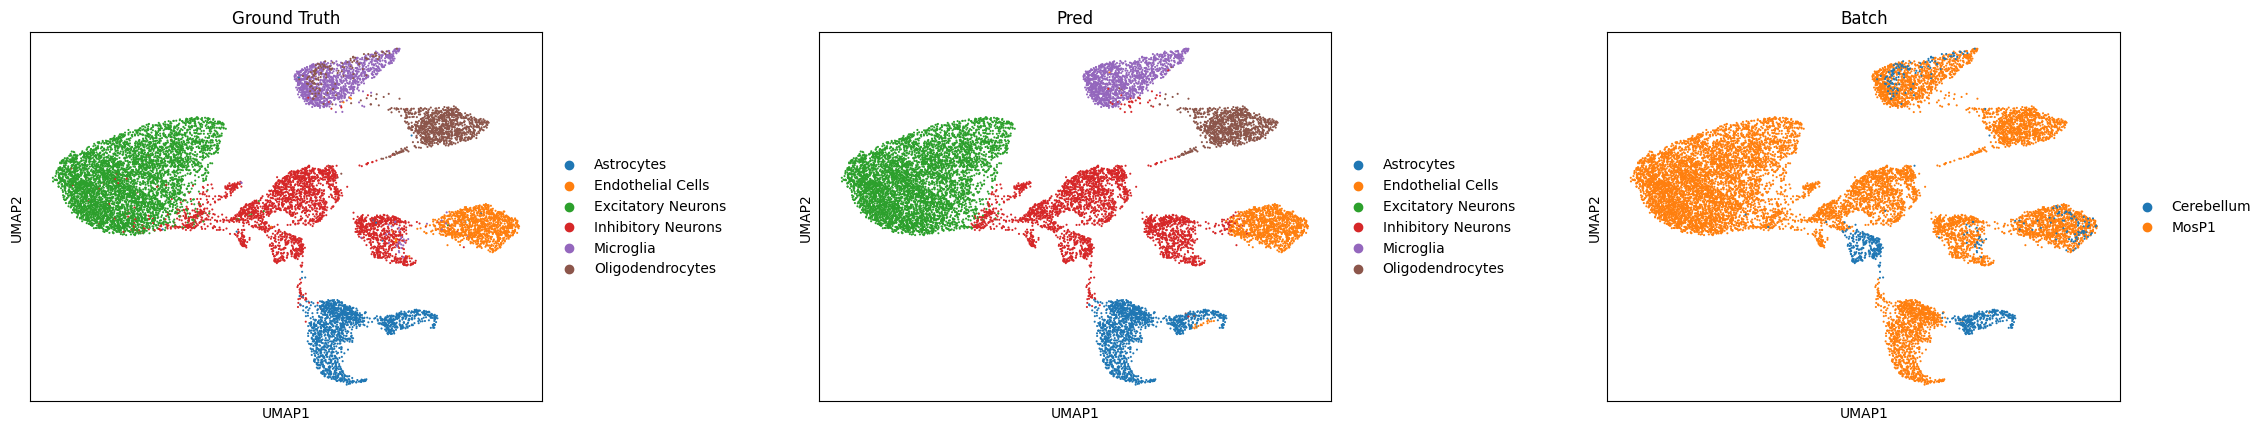

In [10]:
import matplotlib.pyplot as plt

adata = sc.read_h5ad("output/MosP1_Cerebellum/embedding.h5ad")

fontsize = 10
plt.figure(dpi=1200)
sc.pp.neighbors(adata, n_neighbors=25, use_rep='X', n_pcs=40)
sc.tl.umap(adata)
sc.pl.umap(adata, color=["CellType", "Pred", "Batch"], title=["Ground Truth", "Pred", "Batch"],
            legend_fontsize=fontsize,
            wspace=0.4)

<Figure size 7680x5760 with 0 Axes>

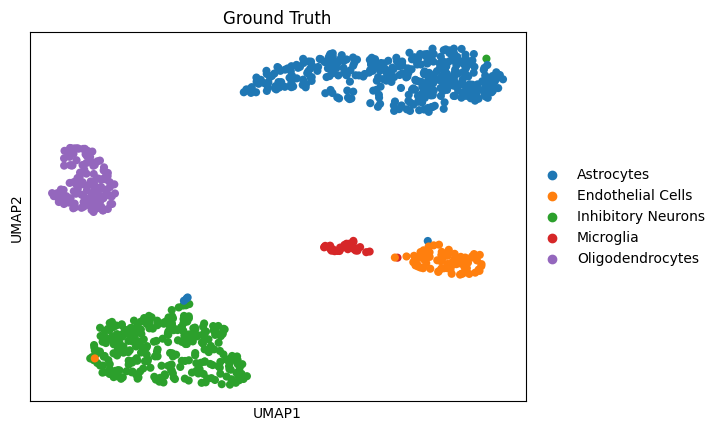

In [11]:
adata = sc.read_h5ad("output/MosP1_Cerebellum/embedding.h5ad")
adata = adata[adata.obs["Batch"] == "Cerebellum"]
fontsize = 10
plt.figure(dpi=1200)
sc.pp.neighbors(adata, n_neighbors=25, use_rep='X', n_pcs=40)
sc.tl.umap(adata)
sc.pl.umap(adata, color=["CellType"], title=["Ground Truth"],
            legend_fontsize=fontsize,
            wspace=0.4)